In [1]:
%matplotlib inline
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, fixed
from IPython.display import clear_output
from datasets.syntheticCT import create_registration_mask


In [10]:
#
# Functions to interactively 
#   - look at the images slice by slice,
#   - overlay two images to compare image registration results
#        
def display_image_planes(image_x, image_y, image_z, image, title=''):
    fig = plt.gcf()
    fig.set_size_inches(30/2.54, 15/2.54)
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    
    img_x = image[image_x,:,:]
    ax1.imshow(sitk.GetArrayViewFromImage(img_x), cmap=plt.cm.Greys_r)
    #ax1.axis("off")
    ax1.set_title('X plane {}'.format(image_x))
    
    img_y = image[:, image_y,:]
    ax2.imshow(sitk.GetArrayViewFromImage(img_y), cmap=plt.cm.Greys_r)
    ax2.axis("off")
    ax2.set_title('Y plane {}'.format(image_y))
    
    img_z = image[:, :, image_z]
    ax3.imshow(sitk.GetArrayViewFromImage(img_z), cmap=plt.cm.Greys_r)
    ax3.axis("off")
    ax3.set_title('Z plane {}'.format(image_z))
    
    fig.suptitle(title, fontsize=30)
    
    fig.tight_layout()
    plt.show()


# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space.
def display_images_planes_with_alpha(image_x, image_y, image_z, alpha, fixed, moving, title=''):
    fig = plt.gcf()
    fig.set_size_inches(60/2.54, 30/2.54)
    ax1 = fig.add_axes([0., 0.55, 0.60, 0.55])
    ax2 = fig.add_axes([0., 0., 0.60, 0.55])
    ax3 = fig.add_axes([0.65, 0., 0.35, 1])
    
    img_x = (1.0 - alpha) * fixed[image_x,:,:] + alpha * moving[image_x,:,:]
    ax1.imshow(sitk.GetArrayViewFromImage(img_x), cmap=plt.cm.Greys_r)
    ax1.axis("off")
    ax1.set_title('X plane {}'.format(image_x), fontsize=24)
    
    img_y = (1.0 - alpha) * fixed[:, image_y,:] + alpha * moving[:, image_y,:]
    ax2.imshow(sitk.GetArrayViewFromImage(img_y), cmap=plt.cm.Greys_r)
    ax2.axis("off")
    ax2.set_title('Y plane {}'.format(image_y), fontsize=24)
    
    img_z = (1.0 - alpha) * fixed[:, :, image_z] + alpha * moving[:, :, image_z]
    ax3.imshow(sitk.GetArrayViewFromImage(img_z), cmap=plt.cm.Greys_r)
    ax3.axis("off")
    ax3.set_title('Z plane {}'.format(image_z), fontsize=24)
    
    fig.suptitle(title, fontsize=30, x = 0.4, y = 1.05)
    plt.show()

def iterations_per_resolution(iterations, metrics):
    splits = np.where(np.diff(iterations) != 1)[0]+1
    return np.split(iterations, splits), np.split(metrics, splits)

def plot_registration_iterations(registration_progress):
    iterations, metrics = iterations_per_resolution(registration_progress[:,0], registration_progress[:,1])
    level = 0
    start = 0
    for iter, metric in zip(iterations, metrics):
        plt.plot(iter + start, metric, label=level)
        level +=1
        start += len(iter)
    plt.xlabel('Iteration')
    plt.ylabel('Similarity Metric')
    plt.legend()

    
def pixel_correlation(image1, image2, mask):
    image_1_np = sitk.GetArrayFromImage(image1)
    image_2_np = sitk.GetArrayFromImage(image2)
    mask_np = sitk.GetArrayFromImage(mask)
    return image_1_np[mask_np > 0.5].flatten(), image_2_np[mask_np > 0.5].flatten()

In [8]:
root = r'P:\TERAPI\FYSIKER\David_Tilly\Rect-5-study\PatientData'
patient_id = '4'
fraction = 'F2'

#root = r'C:\temp\5-days-recti\PatientData'
result_path = os.path.join(root, '{}_anonymized'.format(patient_id), 'synthetic_CT', fraction)


result_path



'P:\\TERAPI\\FYSIKER\\David_Tilly\\Rect-5-study\\PatientData\\4_anonymized\\synthetic_CT\\F2'

In [9]:
ct_ref_float = sitk.ReadImage(os.path.join(result_path, 'ct_ref.nii'))
cbct_float = sitk.ReadImage(os.path.join(result_path, 'cbct.nii'))
cbct_in_ct_for = sitk.ReadImage(os.path.join(result_path, 'cbct_in_ct_for.nii'))
cbct_extended = sitk.ReadImage(os.path.join(result_path, 'cbct_extended.nii'))
cbct_hu_mapped = sitk.ReadImage(os.path.join(result_path, 'cbct_hu_mapped.nii'))
synthetic_ct = sitk.ReadImage(os.path.join(result_path, 'synthetic_ct.nii'))

synthetic_ct_float = sitk.Cast(synthetic_ct, sitk.sitkFloat32)



ct_ref_float.GetPixelIDTypeAsString(), cbct_float.GetPixelIDTypeAsString(), cbct_in_ct_for.GetPixelIDTypeAsString(), cbct_extended.GetPixelIDTypeAsString(), cbct_hu_mapped.GetPixelIDTypeAsString(), synthetic_ct.GetPixelIDTypeAsString()



('32-bit float',
 '32-bit float',
 '32-bit float',
 '32-bit float',
 '32-bit float',
 '16-bit signed integer')

In [11]:

#
# Reference CT and CBCT
#
interact(
    display_image_planes,
    image_x=(0, ct_ref_float.GetSize()[0] - 1),
    image_y=(0, ct_ref_float.GetSize()[1] - 1),
    image_z=(0, ct_ref_float.GetSize()[2] - 1),
    image=fixed(ct_ref_float),
    title=fixed('CT image')
);

interact(
    display_image_planes,
    image_x=(0, cbct_float.GetSize()[0] - 1),
    image_y=(0, cbct_float.GetSize()[1] - 1),
    image_z=(0, cbct_float.GetSize()[2] - 1),
    image=fixed(cbct_float),
    title=fixed('CBCT image')
);



interactive(children=(IntSlider(value=255, description='image_x', max=511), IntSlider(value=255, description='…

interactive(children=(IntSlider(value=134, description='image_x', max=269), IntSlider(value=134, description='…

interactive(children=(IntSlider(value=255, description='image_x', max=511), IntSlider(value=255, description='…

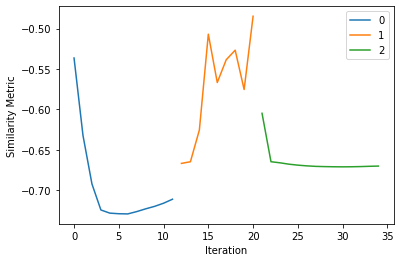

In [12]:
#
# Inspect the rigid registration, overlay of CT wit the resampled CBCT
#
interact(
    display_images_planes_with_alpha,
    image_x=(0, ct_ref_float.GetSize()[0] - 1),
    image_y=(0, ct_ref_float.GetSize()[1] - 1),
    image_z=(0, ct_ref_float.GetSize()[2] - 1),
    alpha=(0.0, 1.0, 0.05),
    fixed=fixed(ct_ref_float),
    moving=fixed(cbct_in_ct_for),
    title=fixed('CT vs CBCT resampled')
);
   

rigid_iterations = np.loadtxt(os.path.join(result_path, 'rigid_registration.txt'))
plot_registration_iterations(rigid_iterations)



In [13]:
#
# Create mask to overwerite all pixels in CT with the resampled CBCT (where pixels > -800)
# Use the CT as a template to extend the anatomy of the CBCT
#

interact(
    display_images_planes_with_alpha,
    image_x=(0, ct_ref_float.GetSize()[0] - 1),
    image_y=(0, ct_ref_float.GetSize()[1] - 1),
    image_z=(0, ct_ref_float.GetSize()[2] - 1),
    alpha=(0.0, 1.0, 0.05),
    fixed=fixed(ct_ref_float),
    moving=fixed(cbct_extended),
    title=fixed('CT vs CBCT extended')
);



interactive(children=(IntSlider(value=255, description='image_x', max=511), IntSlider(value=255, description='…

In [15]:
#
# Compare original CT and mapped CT
#
interact(
    display_images_planes_with_alpha,
    image_x=(0, cbct_hu_mapped.GetSize()[0] - 1),
    image_y=(0, cbct_hu_mapped.GetSize()[1] - 1),
    image_z=(0, cbct_hu_mapped.GetSize()[2] - 1),
    alpha=(0.0, 1.0, 0.05),
    fixed=fixed(ct_ref_float),
    moving=fixed(cbct_hu_mapped),
    title=fixed('CT vs CBCT with mapped HU')
);

#
# Compare synthetic CT and the CBCT (should be same)
#
interact(
    display_images_planes_with_alpha,
    image_x=(0, cbct_hu_mapped.GetSize()[0] - 1),
    image_y=(0, cbct_hu_mapped.GetSize()[1] - 1),
    image_z=(0, cbct_hu_mapped.GetSize()[2] - 1),
    alpha=(0.0, 1.0, 0.05),
    fixed=fixed(cbct_extended),
    moving=fixed(cbct_hu_mapped),
    title=fixed('CBCT extended vs CBCT with mapped HU')
);

def_reg_iterations = np.loadtxt(os.path.join(result_path, 'def_reg_registration.txt'))
plot_registration_iterations(def_reg_iterations)


interactive(children=(IntSlider(value=255, description='image_x', max=511), IntSlider(value=255, description='…

interactive(children=(IntSlider(value=255, description='image_x', max=511), IntSlider(value=255, description='…

C:\Users\tid003\.conda\envs\py37\lib\site-packages\ipykernel_launcher.py:29: UserWarning: loadtxt: Empty input file: "P:\TERAPI\FYSIKER\David_Tilly\Rect-5-study\PatientData\4_anonymized\synthetic_CT\F2\def_reg_registration.txt"


IndexError: too many indices for array

In [16]:
#
# Compare original CT and final synthetic CT
#
interact(
    display_images_planes_with_alpha,
    image_x=(0, synthetic_ct.GetSize()[0] - 1),
    image_y=(0, synthetic_ct.GetSize()[1] - 1),
    image_z=(0, synthetic_ct.GetSize()[2] - 1),
    alpha=(0.0, 1.0, 0.05),
    fixed=fixed(ct_ref_float),
    moving=fixed(synthetic_ct_float),
    title=fixed('CT vs synthetic CT')
);


#
# Compare synthetic CT and the CBCT (should be same)
#
interact(
    display_images_planes_with_alpha,
    image_x=(0, synthetic_ct.GetSize()[0] - 1),
    image_y=(0, synthetic_ct.GetSize()[1] - 1),
    image_z=(0, synthetic_ct.GetSize()[2] - 1),
    alpha=(0.0, 1.0, 0.05),
    fixed=fixed(cbct_extended),
    moving=fixed(synthetic_ct_float),
    title=fixed('CBCT extended vs synthetic CT')
);


interactive(children=(IntSlider(value=255, description='image_x', max=511), IntSlider(value=255, description='…

interactive(children=(IntSlider(value=255, description='image_x', max=511), IntSlider(value=255, description='…

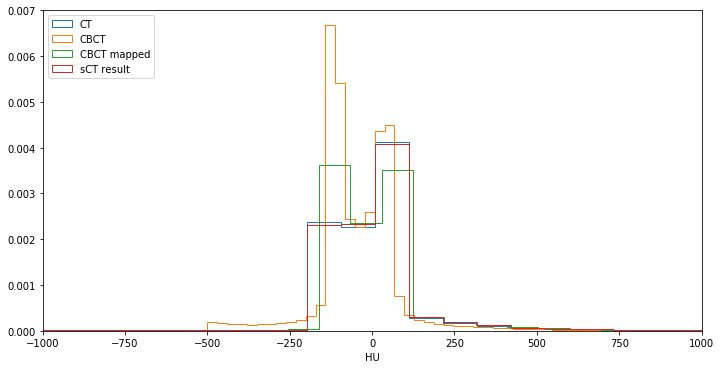

In [17]:
def read_image_series(path):
    
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(path)

    # remove all files starting with filename 'R'
    dicom_names = list(filter( lambda fname: not os.path.basename(fname).startswith('R'), dicom_names))

    reader.SetFileNames(dicom_names)
    ct = reader.Execute()

    ct_float = sitk.Cast(ct, sitk.sitkFloat32)

    return ct_float

s_ct_from_files = read_image_series(result_path)

#
# Pixel to pixel correlation
#
cbct_mask = create_registration_mask(cbct_in_ct_for)


ct_pixels, cbct_pixels = pixel_correlation(ct_ref_float, cbct_in_ct_for, cbct_mask)
cbct_mapped_pixels, cbct_pixels = pixel_correlation(cbct_hu_mapped, cbct_in_ct_for, cbct_mask)
s_ct_pixels, cbct_pixels = pixel_correlation(s_ct_from_files, cbct_in_ct_for, cbct_mask)

#size = ct_ref_float.GetSize()+
#print(len(ct_pixels), len(cbct_pixels), size[0]*size[1]*size[2])

f, ax = plt.subplots(figsize=(30/2.54, 15/2.54))

ax.hist(ct_pixels, bins = 50, label='CT', histtype='step', align='mid', density=True)
ax.hist(cbct_pixels, bins = 50, label='CBCT', histtype='step', align='mid', density=True)
ax.hist(cbct_mapped_pixels, bins = 50, label='CBCT mapped', histtype='step', align='mid', density=True)
ax.hist(s_ct_pixels, bins = 50, label='sCT result', histtype='step', align='mid', density=True)

ax.set_xlim([-1000, 1000])
ax.set_xlabel('HU')
ax.legend()


